In [2]:
%matplotlib ipympl
from mantid.simpleapi import *
from tkinter import *
import matplotlib.pyplot as plt
from mantid.plots.utility import MantidAxType
import numpy as np
from scipy.signal import find_peaks as fp
import matplotlib.pyplot as plt
import math as m 
import json
import pathlib
from datetime import datetime as dt
import pandas as pd
import scipy.interpolate as si
import ipywidgets as widgets
from matplotlib.backend_bases import MouseButton
import lmfit as lm
import threading
import matplotlib
import random as ran
from mantid.geometry import ReflectionGenerator, ReflectionConditionFilter

Find nearest and find nearest ind are both developed from this answer on stack overflow: https://stackoverflow.com/a/2566508
It takes a value and array then tries to find the nearest element to that value in said array. find_nearest_ind then only returns the location of said element.

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_ind(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

These functions are for the peak fits.

In [4]:
def gaussian_function(x, a, x0, sigma,b):
    return b+a*np.exp(-(x-x0)**2/(2*sigma**2))

#This calculates the difference between the data and the fit, using this to determine which parameters to alter
#in order to minimize the fit
def residualGauss(pars,x,data):
    model = gaussian_function(x, a=pars['a'],x0=pars['x0'],sigma=pars['sigma'],b=pars['b']) 
    return model - data

This function takes the run, the experiment conducted, and the bank the user wishes to retrieve the data from.

In [5]:
def fileSearch(run,exp,bank,save=False):
    exps = ['Cryo','Furnace','Pressure','X Scan','Y Scan','Z Scan']
    currdir = os.getcwd() #This finds the folder that the script is being ran in
    savedir = os.path.join(currdir,'Saves') #This creates a new folder to save the data in
    newdir = os.path.join(savedir,'Runs')
    if not os.path.exists(newdir):
        os.makedirs(newdir)
    filedir = os.path.join(newdir,f'{run}')
    
    if len(str(run)) < 5:
        zero_diff = 5 - len(str(run))
        for i in range(zero_diff):
            run = f'0{run}' #This is for significantly early runs, such as 00001 and 00035 from 2002
            
    yr = dt.now().strftime('%y')
    cy = int(yr) + 1

    if bank == '1':
        sMin_One = 0
        sMax_One = 1200 #These are the spectrums to be provided to the load function. After a certain point,
        #the highest and lowest spectrum available to read are 1 and 2399 respectively, so this code factors
        #that in
        sMin_Two = 1
        sMax_Two = 1199
    elif bank == '2':
        sMin_One = 1201
        sMax_One = 2400
        sMin_Two = 1200
        sMax_Two = 2399
    elif bank == 'Both':
        sMin_One = 0
        sMax_One = 2400
        sMin_Two = 1
        sMax_Two = 2399
    else:
        sMin_One = 0
        sMax_One = 2400
        sMin_Two = 1
        sMax_Two = 2399
    for i in reversed(range(2,int(cy))):
        if i < 10:
            year = f'0{i}'
        else:
            year = f'{i}'
        if i < 17:
            #These are the names of all the parameters saved as part of the raw file or folder prior
            #to the apparent overhaul in 2017
            apps = [['cryo_1','cryo_temp1'],'furnace','position','x','y','z']
            if exp == exps[0]:
                if i < 10:
                    app = apps[0][0]
                else:
                    app = apps[0][1]
            elif exp == exps[1]:
                app = apps[1]
            elif exp == exps[2]:
                app = apps[2]
            elif exp == exps[3]:
                app = apps[3]
            elif exp == exps[4]:
                app = apps[4]
            elif exp == exps[5]:
                app = apps[5]
            elif exp == None:
                pass
            else:
                raise NameError(f'This is not included in the list of experiments. Please enter one from this list: {exps}')
        else:
            #These are the current names for the parameters found within the nexus files
            apps = ['Temp_1','Temp_3','position','X_position','Y_position','Z_position']
            if exp == exps[0]:
                app = apps[0]
            elif exp == exps[1]:
                app = apps[1]
            elif exp == exps[2]:
                app = apps[2]
            elif exp == exps[3]:
                app = apps[3]
            elif exp == exps[4]:
                app = apps[4]
            elif exp == exps[5]:
                app = apps[5]
            elif exp == None:
                pass
            else:
                raise NameError(f'This is not included in the list of experiments. Please enter one from this list: {exps}')
        for cycle in [5,4,3,2,1]:
            if i < 8:
                name_one = f'ENG{run}'
                name_two = f'ENG{run}' #This factors in a change in naming convention
            else:
                name_one = f'ENG00{run}'
                name_two = f'ENGINX00{run}'
            ext_one = '.raw'
            ext_two = '.nxs'
            #These four combinations factor in the naming convention of runs mentioned above and the filetype,
            #either nexus or raw
            testdir_one = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_one}{ext_one}'
            testdir_two = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_two}{ext_one}'
            testdir_three = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_one}{ext_two}'
            testdir_four = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_two}{ext_two}'
            check_one = pathlib.Path(testdir_one)
            check_two = pathlib.Path(testdir_two)
            check_three = pathlib.Path(testdir_three)
            check_four = pathlib.Path(testdir_four)
            if check_one.exists():
                dire = testdir_one
                name = f'ENGINX00{run}'
                dSpace = f'{name}-dSpacing'
                sumSpec = f'{name}-sumSpec'
                try:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_One, SpectrumMax=sMax_One)
                except ValueError:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_Two, SpectrumMax=sMax_Two) #For the
                    #different spectrums, mentioned earlier
                ConvertUnits(InputWorkspace=name, OutputWorkspace=dSpace, Target='dSpacing', AlignBins=True)
                SumSpectra(InputWorkspace=dSpace, OutputWorkspace=sumSpec)
                try:
                    #It searches for the parameter in the file
                    temp = mtd[sumSpec].getRun().getLogData(app).filtered_value
                except RuntimeError:
                    print(f'Unable to find {app} in file.')
                    try:
                        #If this doesn't work, it searches for the parameter in the folder
                        temp_fp = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_one}_{app}.txt'
                        temp = np.loadtxt(fname=fp,dtype='float',usecols=(1))
                        if save == True:
                            try:
                                shutil.copy(temp_fp,f'{newdir}')
                            except PermissionError:
                                print('Unable to copy parameter file. May already be saved.')
                    except FileNotFoundError:
                        #If this still doesn't work, it notifies the user and carries on
                        print(f'Unable to find {app} file in folder.')
                        temp = 0
                except UnboundLocalError:
                    temp = 0
                if isinstance(temp, (np.ndarray, list)) == True:
                    try:
                        #This is due to the nature of the txt files some parameters are read from holding more
                        #information than just the parameter the user would like to retrieve
                        temp = temp[-1]
                        temp = round(temp,2)
                    except IndexError:
                        temp = temp
                        temp = round(float(temp),2)
                else:
                    temp = temp
                    temp = round(float(temp),2)
                if save == True:
                    try:
                        shutil.copy(dire,f'{newdir}')
                    except PermissionError:
                        print('Unable to copy file. May already be saved.')
                return dire, temp, sumSpec
            elif check_two.exists():
                #It then repeats this process for every potential name till it finds a fit
                dire = testdir_two
                name = f'ENGINX00{run}'
                dSpace = f'{name}-dSpacing'
                sumSpec = f'{name}-sumSpec'
                try:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_One, SpectrumMax=sMax_One)
                except ValueError:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_Two, SpectrumMax=sMax_Two)
                ConvertUnits(InputWorkspace=name, OutputWorkspace=dSpace, Target='dSpacing', AlignBins=True)
                SumSpectra(InputWorkspace=dSpace, OutputWorkspace=sumSpec)
                try:
                    temp = mtd[sumSpec].getRun().getLogData(app).filtered_value
                except RuntimeError:
                    print(f'Unable to find {app} in file.')
                    try:
                        temp_fp = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_two}_{app}.txt'
                        temp = np.loadtxt(fname=fp,dtype='float',usecols=(1))
                        if save == True:
                            try:
                                shutil.copy(temp_fp,f'{newdir}')
                            except PermissionError:
                                print('Unable to copy parameter file. May already be saved.')
                    except FileNotFoundError:
                        print(f'Unable to find {app} file in folder.')
                        temp = 0
                except UnboundLocalError:
                    temp = 0
                if isinstance(temp, (np.ndarray, list)) == True:
                    try:
                        temp = temp[-1]
                        temp = round(temp,2)
                    except IndexError:
                        temp = temp
                        temp = round(float(temp),2)
                else:
                    temp = temp
                    temp = round(float(temp),2)
                if save == True:
                    try:
                        shutil.copy(dire,f'{newdir}')
                    except PermissionError:
                        print('Unable to copy file. May already be saved.')
                if check_four.exists():
                    dire = testdir_four
                return dire, temp, sumSpec
            elif check_three.exists():
                dire = testdir_three
                name = f'ENGINX00{run}'
                dSpace = f'{name}-dSpacing'
                sumSpec = f'{name}-sumSpec'
                try:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_One, SpectrumMax=sMax_One)
                except ValueError:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_Two, SpectrumMax=sMax_Two)
                ConvertUnits(InputWorkspace=name, OutputWorkspace=dSpace, Target='dSpacing', AlignBins=True)
                SumSpectra(InputWorkspace=dSpace, OutputWorkspace=sumSpec)
                try:
                    temp = mtd[sumSpec].getRun().getLogData(app).filtered_value
                except RuntimeError:
                    print(f'Unable to find {app} in file.')
                    try:
                        temp_fp = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_one}_{app}.txt'
                        temp = np.loadtxt(fname=fp,dtype='float',usecols=(1))
                        if save == True:
                            try:
                                shutil.copy(temp_fp,f'{newdir}')
                            except PermissionError:
                                print('Unable to copy parameter file. May already be saved.')
                    except FileNotFoundError:
                        print(f'Unable to find {app} file in folder.')
                        temp = 0
                except UnboundLocalError:
                    temp = 0
                if isinstance(temp, (np.ndarray, list)) == True:
                    try:
                        temp = temp[-1]
                        temp = round(temp,2)
                    except IndexError:
                        temp = temp
                        temp = round(float(temp),2)
                else:
                    temp = temp
                    temp = round(float(temp),2)
                if save == True:
                    try:
                        shutil.copy(dire,f'{newdir}')
                    except PermissionError:
                        print('Unable to copy file. May already be saved.')
                return dire, temp, sumSpec
            elif check_four.exists():
                dire = testdir_four
                name = f'ENGINX00{run}'
                dSpace = f'{name}-dSpacing'
                sumSpec = f'{name}-sumSpec'
                try:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_One, SpectrumMax=sMax_One)
                except ValueError:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_Two, SpectrumMax=sMax_Two)
                ConvertUnits(InputWorkspace=name, OutputWorkspace=dSpace, Target='dSpacing', AlignBins=True)
                SumSpectra(InputWorkspace=dSpace, OutputWorkspace=sumSpec)
                try:
                    temp = mtd[sumSpec].getRun().getLogData(app).filtered_value
                except RuntimeError:
                    print(f'Unable to find {app} in file.')
                    try:
                        temp_fp = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_two}_{app}.txt'
                        temp = np.loadtxt(fname=fp,dtype='float',usecols=(1))
                        if save == True:
                            try:
                                shutil.copy(temp_fp,f'{newdir}')
                            except PermissionError:
                                print('Unable to copy parameter file. May already be saved.')
                    except FileNotFoundError:
                        print(f'Unable to find {app} file in folder.')
                        temp = 0
                except UnboundLocalError:
                    temp = 0
                if isinstance(temp, (np.ndarray, list)) == True:
                    try:
                        temp = temp[-1]
                        temp = round(temp,2)
                    except IndexError:
                        temp = temp
                        temp = round(float(temp),2)
                else:
                    temp = temp
                    temp = round(float(temp),2)
                if save == True:
                    try:
                        shutil.copy(dire,f'{newdir}')
                    except PermissionError:
                        print('Unable to copy file. May already be saved.')
                return dire, temp, sumSpec
            else:
                pass

#dire,temp,sumSpec = fileSearch(346540,exp='Cryo',bank=None)
#print(dire,temp,sumSpec)

This is an array containing the symbols of all elements in the periodic table. 

In [6]:
element_sym = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca", "Sc", "Ti",
               "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc",
               "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd",
               "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At",
               "Rn", "Fr", "Ra", "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr", "Rf", "Db", "Sg",
               "Bh", "Hs", "Mt", "Ds", "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"]

This allows the user to select the elements they believe to be in the dataset.

In [7]:
elarr = widgets.SelectMultiple(options=element_sym,description='Elements',disabled=False)
elarr

SelectMultiple(description='Elements', options=('H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'M…

The user can use this cell to check the elements selected against the data.

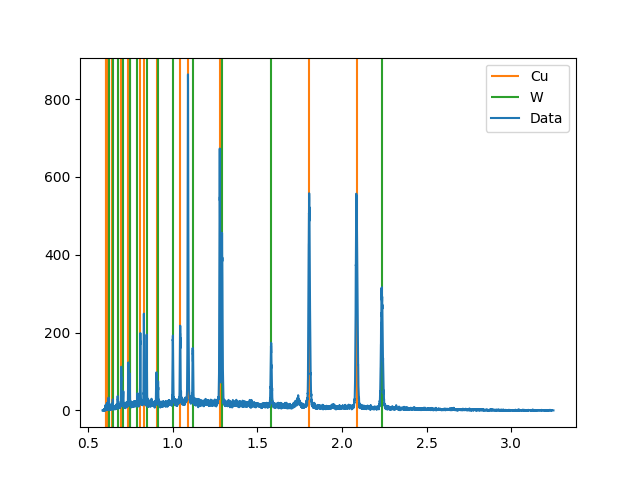

In [28]:
def CIFwData(run,elarr):
    fig,ax = plt.subplots(1)
    _, _, sumSpec = fileSearch(run,exp=None,bank=None)
    y = mtd[sumSpec].dataY(0)
    x = mtd[sumSpec].dataX(0)[0:len(y)]
    drange = [x[0],x[-1]]
    x0 = []
    hkl_arr = []
    for element in elarr:
        #For each element, it opens a cif file then uses Mantid to extract information such as the unit cells
        #and hkls from it
        ws = CreateSampleWorkspace(Function='Multiple Peaks',BankDistanceFromSample=0.01,SourceDistanceFromSample=50)
        LoadCIF(ws,f'C:/Users/ynn46697/Documents/ISIS/Grain_Analysis/Periodic_Table_CIFs/{element}.cif')
        sample = ws.sample().getCrystalStructure()
        unitCell = sample.getUnitCell()
        a = unitCell.a()
        b = unitCell.b()
        c = unitCell.c()
        beta = unitCell.beta()
        struct = sample.getSpaceGroup().getPointGroup().getCrystalSystem()
        pg = sample.getSpaceGroup().getPointGroup()
        generator = ReflectionGenerator(sample)
        hkls = list(generator.getUniqueHKLs(drange[0],drange[-1]))
        #This checks the dictionary to find a more specific crystal structure for the hkl list
        peaks = []
        hkl_temp = []
        for hkl in hkls:
            h = hkl[0]
            k = hkl[1]
            l = hkl[2]
            if struct == "Cubic":
                d_eq = a / m.sqrt(h**2 + k**2 + l**2)
            elif struct == "Hexagonal":
                d_eq = ((m.sqrt(3)*a)/(2*m.sqrt(h**2 + (h * k) + k**2))) + (c/l)
            elif struct == "Tetragonal":
                d_eq = (a / m.sqrt(h**2 + k**2)) + (c / l)
            elif struct == "Orthorhombic":
                d_eq = (a/h) + (b/k) + (c/l)
            elif struct == "Monoclinic":
                d_eq = (m.sqrt(a**2 * m.sin(beta)**2)/h) + (b/k) + (m.sqrt(c**2 * m.sin(beta)**2)/l) - (m.sqrt(a * c * m.sin(beta)**2)/m.sqrt(2 * h * l * m.cos(beta)))
            else:
                #This assumes any undetermined structures to be cubic in order to make things run
                d_eq = a / m.sqrt(h**2 + k**2 + l**2)
            peak = d_eq
            peaks.append(peak)
            x0.append(peak)
        peaks.reverse()
        hkl_arr.append(hkl_temp)
        ax.vlines(peaks, 0, 1, transform=ax.get_xaxis_transform(),color=f'C{elarr.index(element)+1}',linestyles='solid',label=element)
    ax.plot(x,y,label='Data')
    ax.legend()
    plt.show()
    x0.reverse()
    return x0, hkl_arr

elemarr = list(elarr.value)
#Here you input the run you wish to analyse against the elements chosen earlier
x0, hkl_arr = CIFwData(352722,elemarr)

This is the cell used to perform the peak fitting routine with the known elements. It also returns a list of peaks which the user can then use for input in the 3D Data notebook.

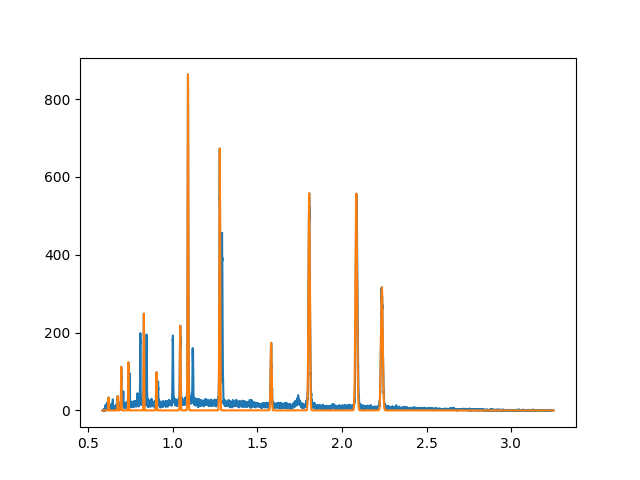

In [29]:
def fitPeaks(run,x0,hkl_arr):
    _, _, sumSpec = fileSearch(run,exp=None,bank=None)
    y = mtd[sumSpec].dataY(0)
    x = mtd[sumSpec].dataX(0)[0:len(y)]
    fig,ax = plt.subplots(1)
    x = list(x)
    x0_base = x0
    x0_ind = []
    yPeak = []
    plot = []
    for i in range(len(x0)):
        #This makes sure the x0 values calculated from the element are in the x data
        x0_new = find_nearest(x, x0[i])
        x0[i] = x0_new
        x0_ind.append(x.index(x0[i]))
    for ind in x0_ind:
        #This searches a range around the peak within the y values to find the true maximum of the peak
        lb = ind - 150
        ub = ind + 150
        x0_range = list(range(lb,ub))
        yPeak_range = y[x0_range]
        yPeak.append(np.amax(yPeak_range))
    y = list(y)
    for i in range(len(yPeak)):
        #This matches the x0 back to the y
        peak_ind = y.index(yPeak[i])
        x0[i] = x[peak_ind]
    for peak in x0:
        x0_idx = x.index(peak)
        height = y[x0_idx]
        #This then calculates the fwhm in order to reverse engineer the width
        xOne = x[x0_idx-75:x0_idx]
        xTwo = x[x0_idx+1:x0_idx+75]
        yOne = y[x0_idx-75:x0_idx]
        yTwo = y[x0_idx+1:x0_idx+75]
        xOne = np.array(xOne)
        xTwo = np.array(xTwo)
        xOneArr = xOne[list(np.argwhere(yOne <= height/2))]
        xTwoArr = xTwo[list(np.argwhere(yTwo <= height/2))]
        try:
            x1 = np.amax(xOneArr)
            x2 = np.amin(xTwoArr)
            fwhm = x2 - x1
            sigma = fwhm / (2 * m.sqrt(2 * m.log(2)))
        except ValueError:
            sigma = peak * 0.05

        #As this is an approximation, the background isn't fitted
        Background = 0
        
        peak_ws = CreateSampleWorkspace()
        #Rather than lmfit, this function uses PlotPeakByLogValue to avoid any shifting peaks
        PeakFitString = f"name=Gaussian,Height={height},PeakCentre={peak},Sigma={sigma}"
        PlotPeakByLogValue(Input=peak_ws, OutputWorkspace='PeakFit', Function=PeakFitString, FitType='Individual')
        fit_res = mtd['PeakFit'].toDict()
        height_fit = fit_res['Height'][0]
        peak_fit = fit_res['PeakCentre'][0]
        sig_fit = fit_res['Sigma'][0]
        x = np.array(x)
        best_fit = gaussian_function(x=x, a=height_fit, x0=peak_fit, sigma=sig_fit,b=Background)
        if x0.index(peak) == 0:
            plot = best_fit
        else:
            for i in range(len(plot)):
                check = np.amax([plot[i],best_fit[i]])
                plot[i] = check
        x = list(x)
    ax.plot(x,y)
    ax.plot(x,plot)
    x0.sort()
    return x0_base, x0, yPeak, plot

x0_base, x0_el, yPeak, plot = fitPeaks(358940,x0,hkl_arr)

In [30]:
print(x0_el)

[0.6202667890091988, 0.6202667890091988, 0.6202667890091988, 0.6740667707550556, 0.6740667707550556, 0.6933329804343151, 0.6951505473851887, 0.6951505473851887, 0.7373181006454548, 0.7373181006454548, 0.7373181006454548, 0.7373181006454548, 0.7373181006454548, 0.7373181006454548, 0.8289234749694812, 0.8289234749694812, 0.8289234749694812, 0.8289234749694812, 0.9034437199552963, 0.9034437199552963, 1.0437598885627335, 1.0895625757247467, 1.0895625757247467, 1.0895625757247467, 1.2774989984450706, 1.2774989984450706, 1.5813961926311264, 1.8060474677590959, 2.0844987246329736, 2.2357202949457444]


Separate from all this, is the Manual Peak Fit. The user selects where they believe the peaks to be located on a plot of the data, and the fit does the rest.

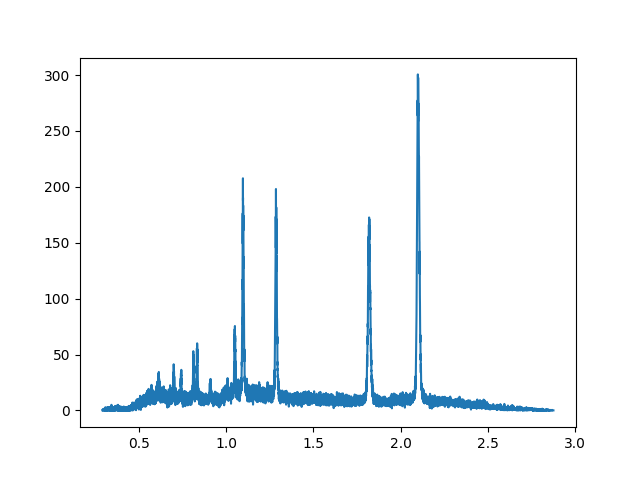

In [18]:
#This recognises when the user selects a peak then stores it in the x0 array
def on_click(event):
    if event.button is MouseButton.LEFT:
        x0.append(event.xdata)

#This calls the event function and plots the data for the user to select from
def manualPeakSel(run):
    _, _, sumSpec = fileSearch(run,exp=None,bank=None)
    y = mtd[sumSpec].dataY(0)
    x = mtd[sumSpec].dataX(0)[0:len(y)]
    global x0
    x0 = []
    event = threading.Event()
    fig,ax = plt.subplots(1)

    ax.plot(x,y)

    cid = fig.canvas.mpl_connect('button_press_event', on_click)
    plt.show()

#Running this function presents a plot where you locate and select the peaks
manualPeakSel(358990)

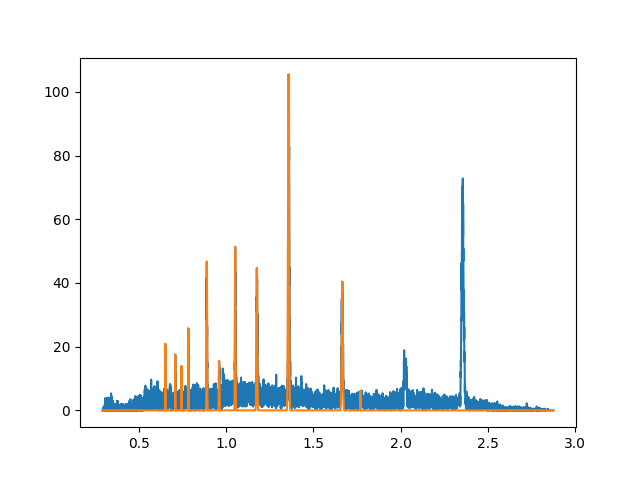

In [10]:
#This function performs the actual fit
def fitPeaksMan(run,x0):
    _, _, sumSpec = fileSearch(run,exp=None,bank=None)
    y = mtd[sumSpec].dataY(0)
    x = mtd[sumSpec].dataX(0)[0:len(y)]
    fig,ax = plt.subplots(1)
    x = list(x)
    x0_ind = []
    yPeak = []
    plot = []
    for i in range(len(x0)):
        x0_new = find_nearest(x, x0[i])
        x0[i] = x0_new
        x0_ind.append(x.index(x0[i]))
    for ind in x0_ind:
        #This performs the same search method as the previous method but with a smaller range as it relies on user input
        lb = ind - 100
        ub = ind + 100
        x0_range = list(range(lb,ub))
        yPeak_range = y[x0_range]
        yPeak.append(np.amax(yPeak_range))
    y = list(y)
    for i in range(len(yPeak)):
        #This matches the x0 back to the y
        peak_ind = y.index(yPeak[i])
        x0[i] = x[peak_ind]
    for peak in x0:
        x0_idx = x.index(peak)
        height = y[x0_idx]
        xOne = x[x0_idx-75:x0_idx]
        xTwo = x[x0_idx+1:x0_idx+75]
        yOne = y[x0_idx-75:x0_idx]
        yTwo = y[x0_idx+1:x0_idx+75]
        xOne = np.array(xOne)
        xTwo = np.array(xTwo)
        xOneArr = xOne[list(np.argwhere(yOne <= height/2))]
        xTwoArr = xTwo[list(np.argwhere(yTwo <= height/2))]
        try:
            #This is a method to calculate the width of a peak from fwhm
            x1 = np.amax(xOneArr)
            x2 = np.amin(xTwoArr)
            fwhm = x2 - x1
            sigma = fwhm / (2 * m.sqrt(2 * m.log(2)))
        except ValueError:
            #This is a less accurate method to allow the code to run regardless
            sigma = 0.05 * peak
        Background = 0
        
        peak_ws = CreateSampleWorkspace()
        PeakFitString = f"name=Gaussian,Height={height},PeakCentre={peak},Sigma={sigma}"
        PlotPeakByLogValue(Input=peak_ws, OutputWorkspace='PeakFit', Function=PeakFitString, FitType='Individual')
        fit_res = mtd['PeakFit'].toDict()
        height_fit = fit_res['Height'][0]
        peak_fit = fit_res['PeakCentre'][0]
        sig_fit = fit_res['Sigma'][0]
        x = np.array(x)
        best_fit = gaussian_function(x=x, a=height_fit, x0=peak_fit, sigma=sig_fit,b=Background)
        x = list(x)
        if x0.index(peak) == 0:
            plot = best_fit
        else:
            for i in range(len(plot)):
                check = np.amax([plot[i],best_fit[i]])
                plot[i] = check
    ax.plot(x,y)
    ax.plot(x,plot)
    return x0, yPeak, plot

x0, yPeak, plot = fitPeaksMan(346541,x0)

In [13]:
print(x0)

[2.366442140876212, 2.354986744774969, 2.0170525597883056, 1.6733906767510207, 1.3583672839668428, 1.1865363424482005, 1.0605269853345292, 0.9631561184739652, 0.8944237418665082, 0.7913251769553227, 0.7512312906009728, 0.711137404246623, 0.6595881217910301]
